In [2]:
import mne
import numpy as np
import pandas as pd
from pymatreader import read_mat
import matplotlib.pyplot as plt
import scipy
from sklearn.cross_decomposition import CCA
import seaborn as sns

In [3]:
data = read_mat("S001-S010/S005.mat")
np_data = np.array(data['data'])
np_data.shape

(8, 710, 2, 10, 12)

In [4]:
# We can interpret this shape as 8 channels, 710 time points, 2 electrodes, 10 blocks, and 12 targets)
#Given that the sampling rate was 250Hz, we can calculate that each of these time points were done in the following
# amount of seconds.
print("{} Seconds".format(np_data.shape[1] / 250))

2.84 Seconds


In [5]:
#Lets establish these frequencies for later.
frequencies = [9.25, 11.25, 13.25, 9.75, 11.75, 13.75, 10.25, 12.25, 14.25, 10.75, 12.75, 14.75]

<h2>Time filtering</h2>

<p>Note that this time includes:
- 0.50s pre stimulus
- 2.00s for actual stimulation
- 0.14s for visual latency.
- 0.20s after stimulus
As for our signal, we only really want the 2.00s of stimulation.

So, of our 710 time points, we only really want to take

from (0.5 / 2.84) * 710 = 125

to ((0.5 + 2) / 2.84) * 710 = 625

This leaves us with 500 actual data points, at 250Hz, this is 2s of measurements


</p>



<h2>Electrodes</h2>

In this case, to replicate the conditions that we experience with watolink, we only really want to take the dry electrode. This corresponds to the first element in the shape of 2.

<h2>Targets</h2>

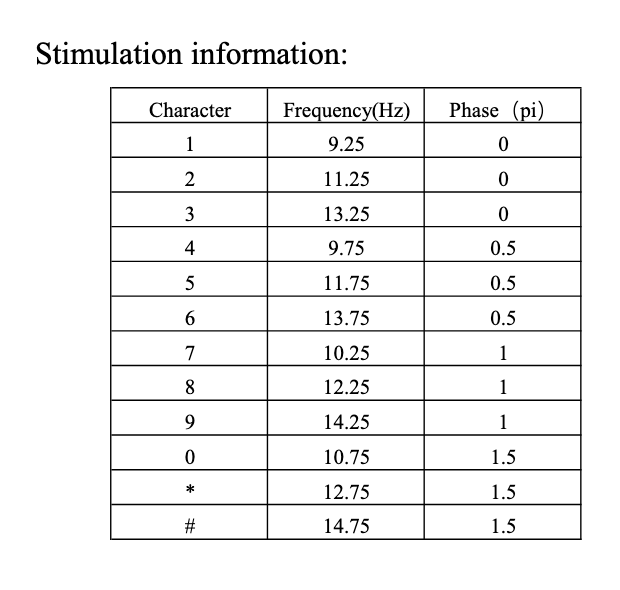

<h2>Blocks</h2>

<p>Just repeated instances of trials. We start by taking one at a time.</p>

In [6]:
#So, filtering our data should look like the following.

# Remove the unwanted time points.
# Remove the wet electrode
# Start with first block
# Start with the first_trial (9.25 Hz, 0 phase)
time_cropped_data = np_data[:, 126:626, 0, :, :]
# print(time_cropped_data.shape)
# data_first_block = time_cropped_data[:, :, 1, 5, 0]
# print(data_first_block.shape)
# eeg_data = data_first_block.T

In [7]:
time_points = np.arange(0, 2, 1/250) # 0s to 2s, 250Hz
#for channel in range(0, 8):
    #plt.scatter(x=time_points, y=eeg_data[:, channel])

<h2>Application of Cannonical Correlation Analysis to This Task</h2>

based on what we've seen thus far of CCA, it works by finding linear combinations of channels that maximize the correlation between two views. Our first view then, can be our 8 channels, and our second view can be points at dedicated reference frequencies. We can start by geenrating our reference signals

In [8]:
#For this we need a sin function of 9Hz that samples at 250Hz,
#Remember that the frequency is set by 2 * pi * frequency
#So the frequnecy of our sin function is 2 * pi * 9Hz

#Similarly, we need to sample at 250Hz. This means that we need we need to grab a value from this function
#Every 1/250th of a second

In [9]:
def make_SSVEP_prediction(data, freq, harmonics=2):
    #Time points
    time_points = np.arange(0, 2, 1/250) # 0s to 2s, 250Hz
    results = {}
    
    for f in freq:
        ref_signals = []
        for h in range(1, harmonics+1):  # Add harmonics
            ref_sin = np.sin(2 * np.pi * f * h * time_points)
            ref_cos = np.cos(2 * np.pi * f * h * time_points)
            ref_signals.extend([ref_sin, ref_cos])
        reference = np.array(ref_signals).T
        #rint(reference.shape)

        cca = CCA(n_components=1)

        #print(data.shape, reference.shape)
    
        eeg_transformed, reference_a = cca.fit_transform(data, reference)
        
        # Find the correlation now:
        results[f] = np.corrcoef(eeg_transformed.T, reference_a.T)[0,1]

    return results




In [10]:
# Now we can run a simulation to see how accurately we would be able to classify the SSVEP
# Signals across all tests.
success = 0
total = 10*12

for freq_i in range(0, 12):
    for block in range(0, 10):
        eeg_data = time_cropped_data[:, :, block, freq_i].T
        results = make_SSVEP_prediction(eeg_data, frequencies)
        #print(frequencies[freq_i])
        if max(results, key=results.get) == frequencies[freq_i]:
            success += 1

print("Accuracy: {0}%".format(success / total * 100))
    

Accuracy: 60.83333333333333%


In [11]:
#Clearly some work needs to be done to get this working as expected 

In [12]:
#Let's try this again except with some preprocessing of the data: Let's start with scaling and a bandpass
#filter to remove undesired frequencies
def bandpass(data, low, high, fs=250, order=5):
    nyq = 0.5 * fs
    b, a = butter(order, [low/nyq, high/nyq], btype='band')
    return filtfilt(b, a, data, axis=0)

In [15]:
from sklearn.preprocessing import StandardScaler

#Now run our tests again
# Now we can run a simulation to see how accurately we would be able to classify the SSVEP
# Signals across all tests.

accuracies = np.zeros(10)

for patient in range(1, 11):

    if patient >= 10:
        data = read_mat("S001-S010/S0{0}.mat".format(patient))
    else:
        data = read_mat("S001-S010/S00{0}.mat".format(patient))
    np_data = np.array(data['data'])
    time_cropped_data = np_data[:, 126:626, 0, :, :]

    success = 0
    total = 10*12
    
    for freq_i in range(0, 12):
        for block in range(0, 10):
            eeg_data = time_cropped_data[:, :, block, freq_i].T
            #Standardize our size
            scaler = StandardScaler()
            eeg_data_filtered = scaler.fit_transform(eeg_data) #This removes the mean from each entry, and expresses all measurements within a standard deviation
            
            #Bandpass filter (4-30Hz)
            from scipy.signal import butter, filtfilt
    
            eeg_data = bandpass(eeg_data_filtered, 4, 30)
            results = make_SSVEP_prediction(eeg_data_filtered, frequencies)
            #print(frequencies[freq_i])
            if max(results, key=results.get) == frequencies[freq_i]:
                success += 1
    
    print("Accuracy for patient {0}: {1}%".format(patient, success / total * 100)) 
    accuracies[patient-1] = success/total * 100

Accuracy for patient 1: 37.5%
Accuracy for patient 2: 21.666666666666668%
Accuracy for patient 3: 50.0%
Accuracy for patient 4: 94.16666666666667%
Accuracy for patient 5: 60.83333333333333%
Accuracy for patient 6: 35.0%
Accuracy for patient 7: 61.66666666666667%
Accuracy for patient 8: 64.16666666666667%
Accuracy for patient 9: 53.333333333333336%
Accuracy for patient 10: 64.16666666666667%


Text(0, 0.5, 'Patient no.')

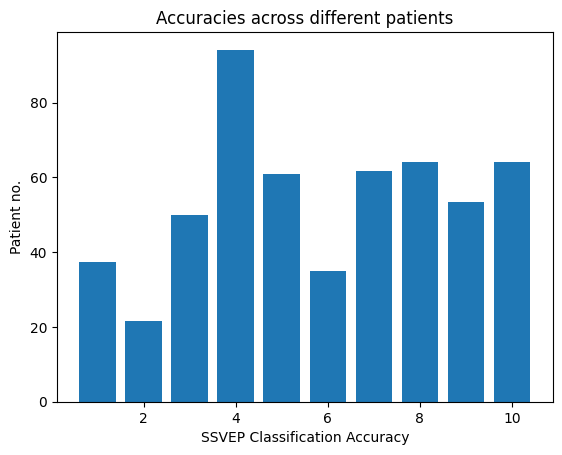

In [16]:
x = np.linspace(1, 10, 10)
plt.bar(x=x, height=accuracies)
plt.title("Accuracies across different patients")
plt.xlabel("SSVEP Classification Accuracy")
plt.ylabel("Patient no.")